In [9]:
import pandas as pd
import numpy as np
import requests
from requests.exceptions import HTTPError
import glog
from ratelimit import rate_limited

import riskfolio as rp
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pypfopt.efficient_frontier import EfficientFrontier
import time
from pypfopt import plotting

Bonus
- Deal with appropriate HTTP status error codes  
- A plot of the mean-variance efficient frontier  
- Write output a location  

In [2]:
class config:
    binance_api_url = " https://fapi.binance.com/fapi/v1/klines"
    start_time = pd.to_datetime("2023-09-01")
    end_time = pd.to_datetime("2023-09-02")
    data_freq = "1h"
    symbol_list =["BTC", "ETH", "LTC"]
    data_fetch_max_trial = 5
    s_2_ms_convert_multiplier = 1e3

## 0 Get Data
- Error capture, the api donot return other status code than 200, and result.ok is always truen only return status field in the data.
- https://www.htx.com/support/es-la/detail/44922980135519 as LTC is suspended, so I decide

In [3]:
 # 10 times/second for one IP at most
    
# request the data
@rate_limited(calls=10, period=1) 
def request_data(request_params):
    response = requests.get(config.binance_api_url, request_params)
    # handle response.status_code here
    
    if response.status_code == 200:
        return response
    else:
        glog.error(f"Request failed with status code {response.status_code} res {response.json()}")
        return None
    
def get_price_data(symbol):
    glog.info(f"Start to fetch data for {symbol}")
    
    request_params = {
                    "symbol": f"{symbol}USDT",
                    "interval": config.data_freq,
                    "startTime": int(config.start_time.timestamp() * config.s_2_ms_convert_multiplier),
                    "endTime": int(config.end_time.timestamp() * config.s_2_ms_convert_multiplier)
                    }
  
    for i in range(config.data_fetch_max_trial):
        try:
            res = request_data(request_params)
            df_data = pd.DataFrame(res.json())
            if res is not None:
                break
        except HTTPError as e:
            time.sleep(1)
            glog.error(f"HTTPError! {e}")
            
    # parse data
    # df_data_all = pd.concat(df_data_all_list, ignore_index=True)
    df_perp_price = df_data.copy(deep=True)
    df_perp_price.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
                           'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
                           'taker_buy_quote asset_volume', 'dummy']
    df_perp_price['time'] = pd.to_datetime((df_perp_price['timestamp'].astype('int')) * 1e6).apply(
        lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
    df_perp_price['time'] = pd.to_datetime(df_perp_price['time'])
    df_perp_price = df_perp_price.astype({'close': float})
    return df_perp_price

In [4]:
return_series_list = []

for symbol in config.symbol_list:
    df_perp_price = get_price_data(symbol)
    return_series = df_perp_price['close'].pct_change()
    return_series.index = df_perp_price['time']
    return_series.dropna(inplace=True)
    return_series.name = symbol
    return_series_list.append(return_series)

I1104 14:19:25.953700 47332 1841806022.py:16] Start to fetch data for BTC
I1104 14:19:26.382643 47332 1841806022.py:16] Start to fetch data for ETH
I1104 14:19:26.746453 47332 1841806022.py:16] Start to fetch data for LTC


In [5]:
df_return = pd.concat(return_series_list, axis=1)

## 2 Allocation preparation

In [10]:
# config
df_data = df_return.copy(deep=True)

n_assets = df_data.shape[1]
T = df_data.shape[0]
quarterly_conversion_factor = 4

lamda = 500
r = 0.02

asset_weights_benchmark = np.array([0.3, 0.2, 0.3, 0.2, 0]) # The GIC baseline allocation

# calculate hitorical returns
assets_return = df_data.mean().values 
assets_cov = df_data.cov().values
assets_ones = np.ones(n_assets)

# for poltting
zero_series = pd.Series([0]*df_data.shape[0], index=df_data.index)

In [11]:
assets_return

array([-0.00041062, -0.00056976, -0.00065064])

In [12]:
# define the functions we need
def analyze_performance(asset_weights):
    return_portfolio = (assets_return @ asset_weights) * quarterly_conversion_factor
    volatility_portfolio= np.sqrt((asset_weights @ assets_cov @ asset_weights) * quarterly_conversion_factor)
    sharpe_portfolio  = (return_portfolio - r)/ volatility_portfolio
    print(f"Annually Return {return_portfolio*100:.3f}%,\n Annually Volatility {volatility_portfolio*100:.3f}%,\n Sharpe {sharpe_portfolio:.3f}")
    
def plot_asset_weights(asset_weights, label=''):
    asset_weights = pd.DataFrame(asset_weights, index=df_data.columns)

    plt.figure(figsize = [6,6], dpi=50)
    ax = rp.plot_pie(w=asset_weights,
                     title=label,
                     others=0.05,
                     nrow=25,
                     cmap = "tab20",
                     height=6,
                     width=10,
                     ax=None)
    plt.show()

def plot_asset_returns(asset_weights, label=''):
    plt.figure(figsize=[18,5], dpi=200)
    plt.title(f"{label} Asset Returns")
    
    for index, col in enumerate(df_data.columns):
        plt.plot(df_data[col] * asset_weights[index] / n_assets, label=col)
    plt.plot(zero_series, label='zero', color='gray', linestyle='--')    
    plt.legend()
    # plt.savefig(f"./picture/{label}_asset_returns.png")
    plt.show()
    
    
def plot_portfolio_returns(asset_weights, label=''):
    fig,ax1 = plt.subplots(figsize=[18,5], dpi=200)
    plt.title(f"{label} Portfolio Returns & Cumulative Returns")

    plt.plot(zero_series, label='zero', color='gray', linestyle='--', linewidth=2)
    ax2 = ax1.twinx()           

    ax1.plot((df_data * asset_weights).mean(axis=1), label='returns', color='orange')
    ax1.set_ylabel('returns')
    ax1.legend()

    ax2.plot(((df_data * asset_weights).mean(axis=1) + 1).cumprod(), label='cumulative_returns')
    ax2.set_ylabel('cumulative_returns')
    ax2.legend()
    # plt.savefig(f"./picture/{label}_portfolio_returns.png")
    plt.show()

## 3 Markowitz Mean-Variance Framework
- Markowitz

In [13]:
ef = EfficientFrontier(assets_return, assets_cov, weight_bounds=[-1,1])
weights = ef.max_quadratic_utility(risk_aversion=lamda, market_neutral=False)
cleaned_weights = ef.clean_weights()
asset_weights_markowitz = pd.DataFrame(cleaned_weights, index=['weights']).values[0]
asset_weights_markowitz

array([ 0.68374,  0.58393, -0.26767])

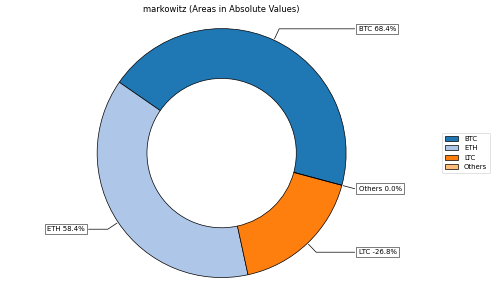

In [257]:
plot_asset_weights(asset_weights_markowitz, label='markowitz')

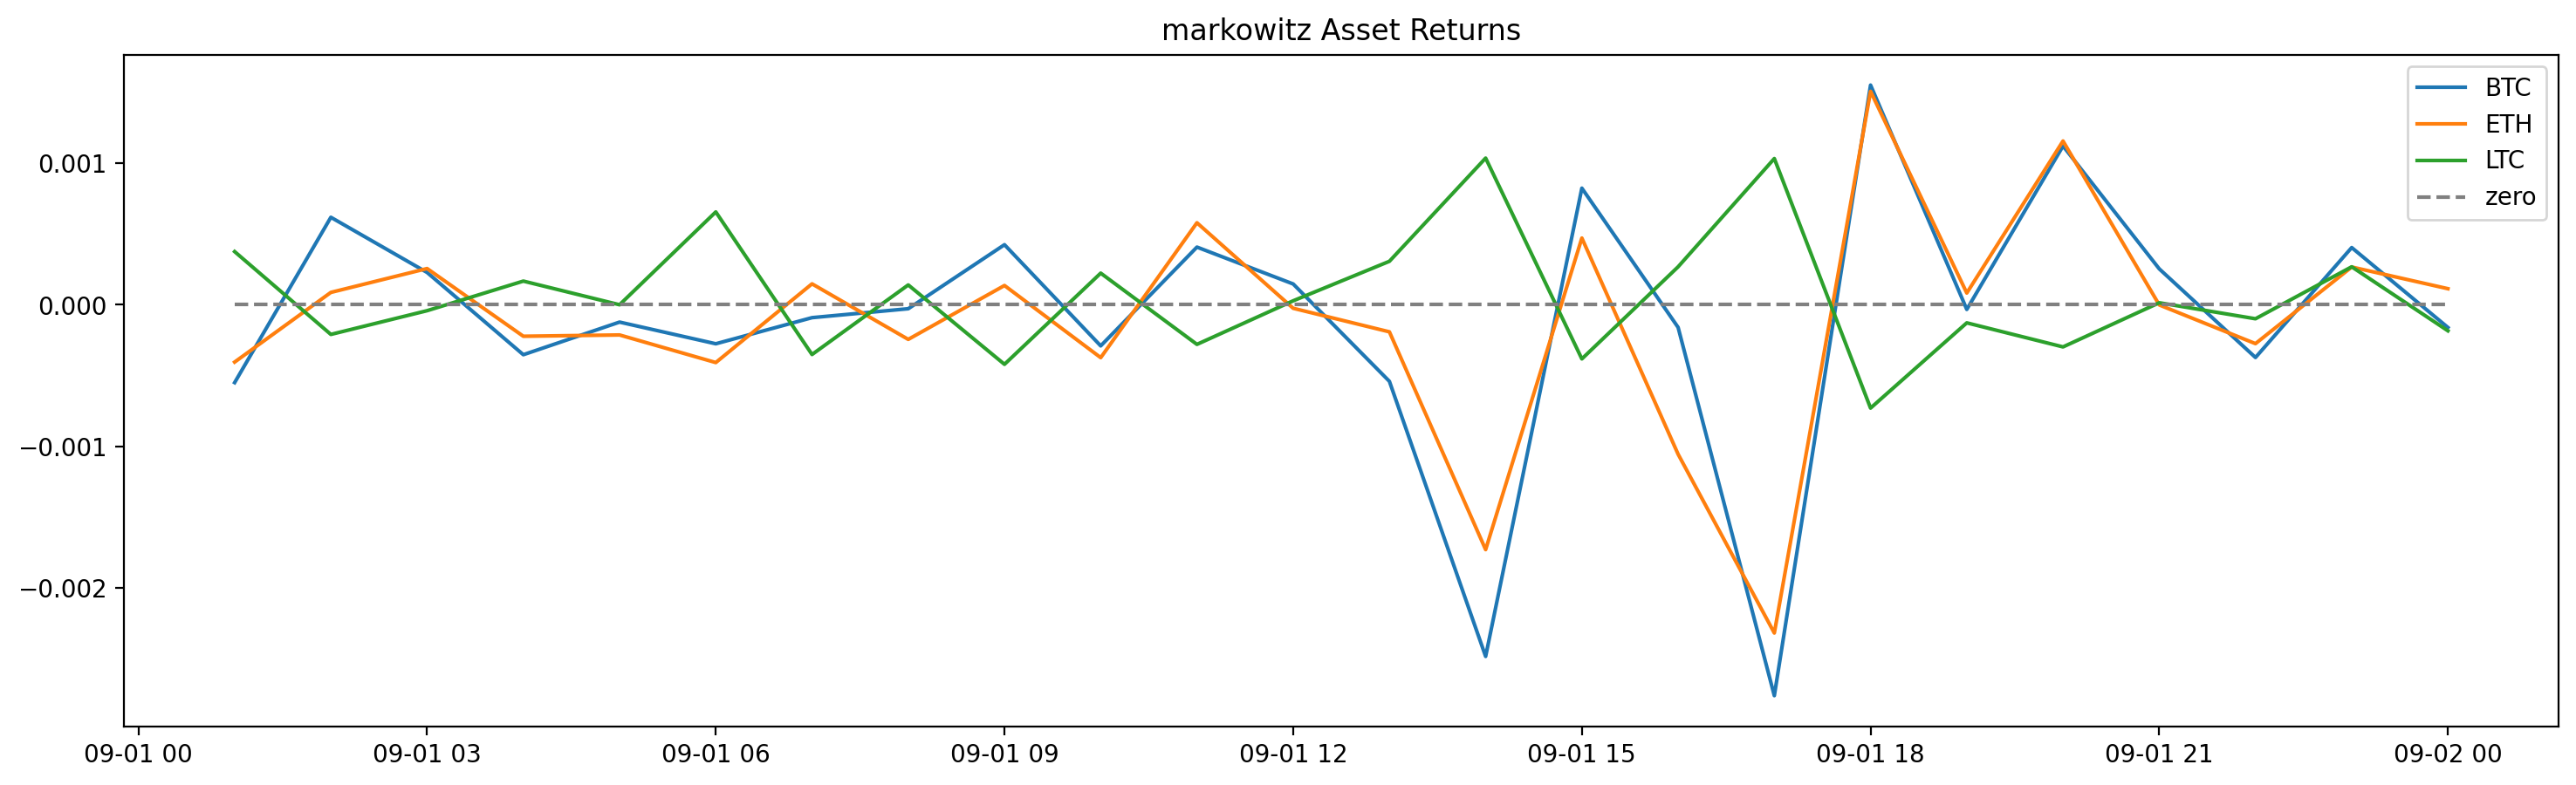

In [258]:
plot_asset_returns(asset_weights_markowitz, label='markowitz')

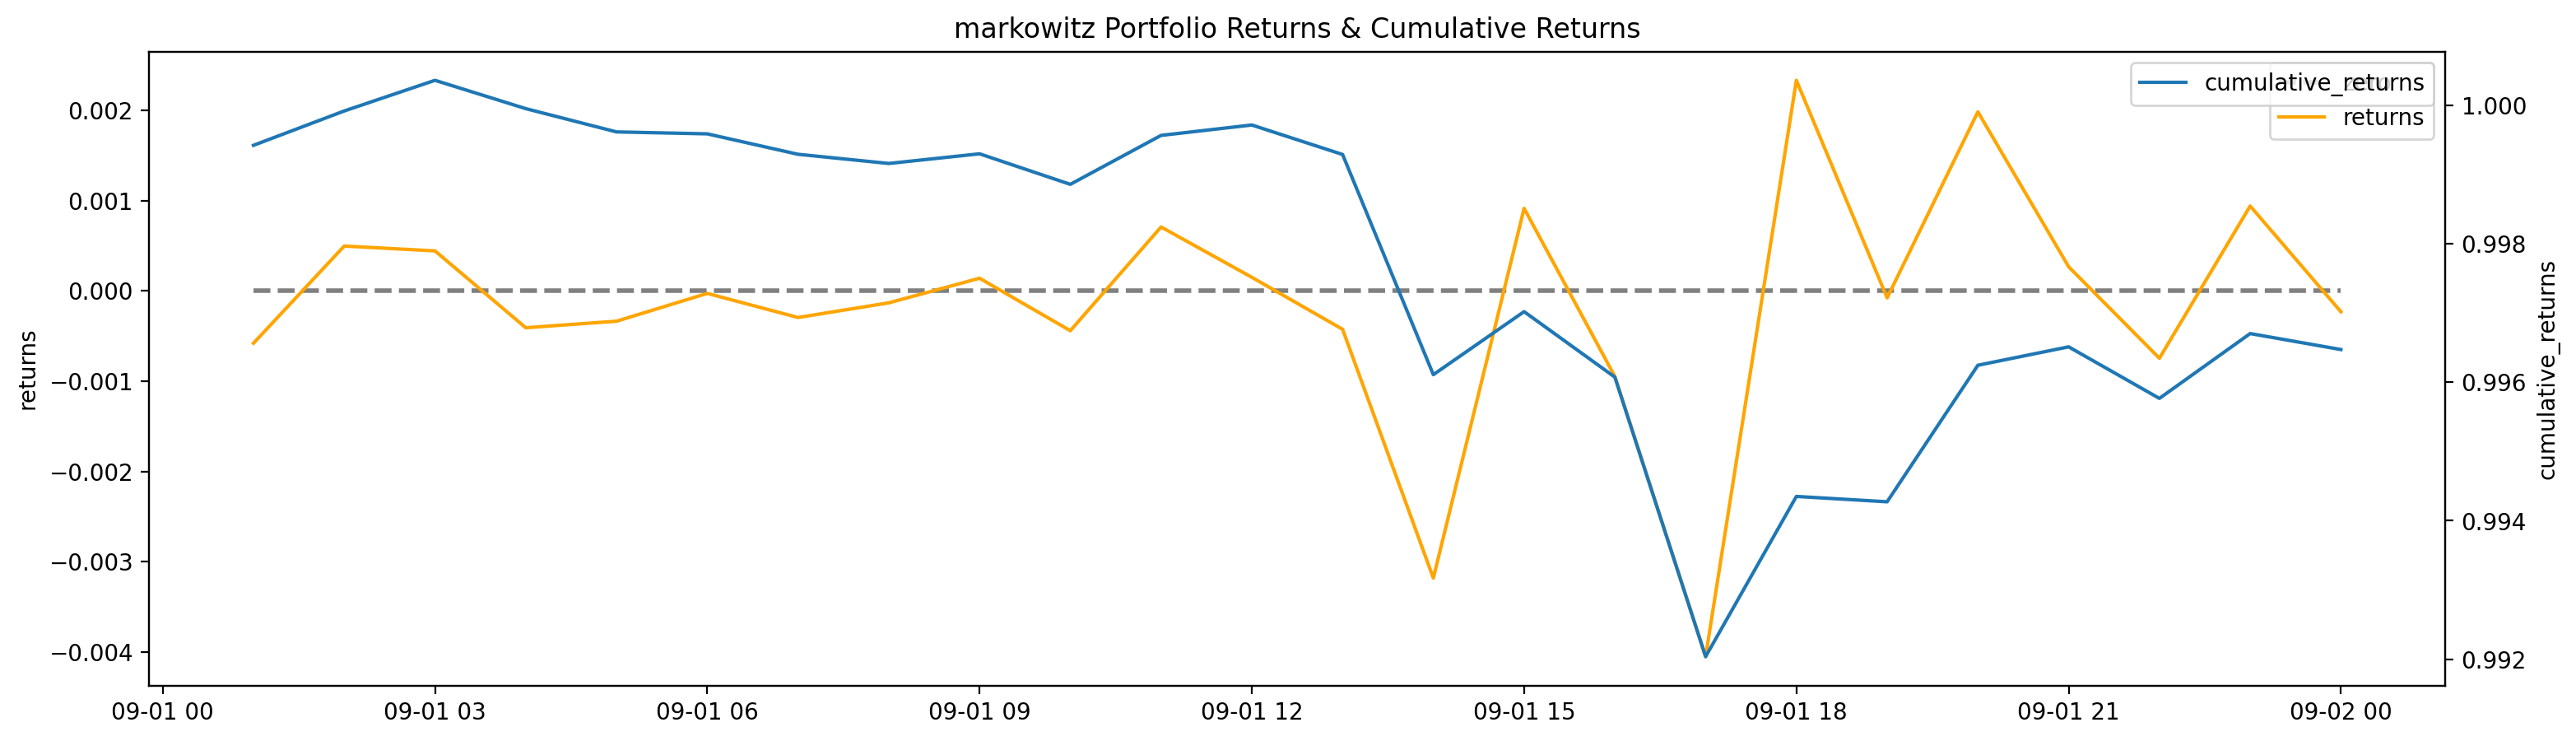

In [259]:
plot_portfolio_returns(asset_weights_markowitz, label='markowitz')

In [260]:
analyze_performance(asset_weights_markowitz)

Annually Return -0.176%,
 Annually Volatility 0.799%,
 Sharpe -2.723
